# Deep Sets Model for Jet Constituent-Based Classification

This section implements a Deep Sets architecture to classify jets as QCD background or Higgs signal using variable-length per-constituent features. Each jet is treated as a set of its constituents, such as tracks, and processed in a permutation-invariant manner.

The model follows the Deep Sets principle:

Applies shared dense layers across all constituents.

Uses GlobalAveragePooling1D to aggregate information over the set.

Final dense layers perform classification on the aggregated representation.

Key features:

Designed to handle variable numbers of constituents.

Inputs are padded and truncated to a fixed number (n<sub>tracks</sub>).

Applies jet selection:

Mass: 40 GeV < M<sub>sd</sub> < 200 GeV

p<sub>T</sub>: 300 GeV < p<sub>T</sub> < 2000 GeV

Performance is evaluated using the ROC curve and AUC, showing the model’s ability to learn directly from low-level constituent information in a physics-aware way.

In [1]:
# ======================================================================================
# Import core Python and scientific libraries
# ======================================================================================
import numpy as np                      # Numerical operations and array handling
import uproot                           # Read ROOT files (used in HEP)
import fsspec_xrootd                    # Enables reading ROOT files over XRootD protocol

# ======================================================================================
# Load configuration: features, labels, spectators, etc.
# ======================================================================================
import yaml                             # For reading YAML config files

from utilities.deepset_adversarial_datagenerator import DataGenerator
# Custom Keras DataGenerator for handling particle physics data
# Applies event-level filtering, padding, batching

# ======================================================================================
# Plotting tools (CMS ROOT-like style)
# ======================================================================================
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)           # Set plotting style to mimic ROOT (CMS-style)

# ======================================================================================
# TensorFlow / Keras deep learning setup
# ======================================================================================
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, \
                                    GlobalAveragePooling1D, Dropout, Flatten
import tensorflow.keras.backend as K    # Lower-level TF operations, e.g., for custom loss

# ======================================================================================
# Keras training callbacks
# ======================================================================================
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# EarlyStopping: stop training if validation loss doesn’t improve
# ModelCheckpoint: save best model during training
# ReduceLROnPlateau: reduce learning rate if model gets stuck

# ======================================================================================
# Performance evaluation (AUC, ROC, etc.)
# ======================================================================================
from sklearn.metrics import roc_curve, auc
# roc_curve: calculate TPR/FPR at various thresholds
# auc: compute Area Under ROC Curve


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print("Running on:", tf.config.list_physical_devices())

Running on: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
with open('./utilities/definitions_gnn_deepset_adversarial.yml', 'r') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

In [4]:
# ======================================================================================
# File paths for training, validation, and test datasets
# ======================================================================================
train_files = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_10.root']
val_files   = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_11.root']
test_files  = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_0.root']


# ======================================================================================
# Create the training data generator
# ======================================================================================
train_generator = DataGenerator(
    train_files,               # List of training ROOT files
    features,                  # List of input features per particle
    labels,                    # List of labels (e.g., 'label_H_bb', 'label_QCD_*')
    spectators,                # List of spectator features (e.g., mass, pt)
    batch_size=1024,           # Number of events per training batch
    n_dim=ntracks,             # Maximum number of tracks per event (padding if needed)
    remove_mass_pt_window=True,   # Apply cut: 40 < mass < 200 and 300 < pt < 2000
    remove_unlabeled=True,        # Remove samples with no label (both y=0)
    max_entry=500               # Limit to 5000 entries from file for speed/testing
)

# ======================================================================================
# Create the validation data generator
# ======================================================================================
val_generator = DataGenerator(
    val_files,
    features,
    labels,
    spectators,
    batch_size=1024,
    n_dim=ntracks,
    remove_mass_pt_window=True,
    remove_unlabeled=True,
    max_entry=int(2000 * 0.1)  # Use 10% (~2000 entries) for validation
)

# ======================================================================================
# Create the test data generator
# ======================================================================================
test_generator = DataGenerator(
    test_files,
    features,
    labels,
    spectators,
    batch_size=1000,
    remove_unlabeled=True,
    remove_mass_pt_window=True,
    n_dim=ntracks,
    max_entry=int(2000 * 0.2)  # Use 20% (~4000 entries) for testing
)

In [5]:
# ======================================================================================
# Define DeepSet Model in Keras
# ======================================================================================
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D

# Input shape: (batch_size, ntracks, nfeatures)
inputs = Input(shape=(ntracks, nfeatures), name='input')

# Normalize features per particle
x = BatchNormalization(name='Bn_1')(inputs)

# Shared MLP over tracks
x = Dense(128, activation='relu', name='dense_1')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', name='dense_2')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', name='dense_3')(x)

# Pool across particles to get event-level representation
x = GlobalAveragePooling1D(name='pool_1')(x)

# Event-level MLP
x = Dense(100, activation='relu', name='dense_4')(x)

# Output layer with softmax for multi-class classification (or binary)
outputs = Dense(nlabels, activation='softmax', name='output')(x)

# Create and compile model
deepset_model = Model(inputs=inputs, outputs=outputs)
deepset_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',   # use 'binary_crossentropy' for 1-hot (2 classes)
                      metrics=['accuracy'])

# Display model summary
deepset_model.summary()


2025-07-11 11:05:15.969236: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-11 11:05:15.969254: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-11 11:05:15.969258: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-11 11:05:15.969271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-11 11:05:15.969278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 60, 74)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bn_1 (BatchNormalization)       │ (None, 60, 74)         │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60, 128)        │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (GlobalAveragePooling1D) │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,014 (113.34 KB)

 Trainable params: 28,866 (112.76 KB)

 Non-trainable params: 148 (592.00 B)

In [6]:
# ======================================================================================
# Define callbacks to control training behavior
# ======================================================================================

# Reduce learning rate if validation loss doesn't improve for 5 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Metric to monitor
    patience=5,              # Wait 5 epochs with no improvement
    factor=0.5,              # Reduce LR by half
    verbose=1
)

# Save the best model (by validation loss)
model_check = ModelCheckpoint(
    './trained_models/new_models/keras_model_best_deepset.keras',  # Save path
    monitor='val_loss',
    save_best_only=True,     # Only save if model improved
    save_weights_only=False  # Save full model (structure + weights)
)

# Stop training early if no improvement in validation loss for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=False  # Since you're reloading manually after
)

# Combine callbacks into a list
callbacks = [reduce_lr, model_check, early_stopping]


# ======================================================================================
# Train the model with generator-based data loading
# ======================================================================================

history_deepset_model = deepset_model.fit(
    train_generator,                 # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=50,                       # Max number of epochs
    steps_per_epoch=len(train_generator),      # Steps per training epoch
    validation_steps=len(val_generator),       # Steps per validation epoch
    callbacks=callbacks             # Apply callbacks defined above
)


# ======================================================================================
# Reload the best model (based on validation loss)
# ======================================================================================
deepset_model = load_model('./trained_models/new_models/keras_model_best_deepset.keras')

/Users/sashibhusansahoo/miniforge3/envs/hep/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-07-11 11:05:21.131457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4645 - loss: 0.7891 - val_accuracy: 0.7222 - val_loss: 0.5864 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5871 - loss: 0.6800 - val_accuracy: 0.7361 - val_loss: 0.5533 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7161 - loss: 0.6209 - val_accuracy: 0.7083 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7290 - loss: 0.5803 - val_accuracy: 0.6944 - val_loss: 0.5674 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7548 - loss: 0.5452 - val_accuracy: 0.6944 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7419 - loss: 0.5312 - val_accuracy: 0.7083 - val_loss: 0.6243 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7677 - loss: 0.5061
Epoch 7: ReduceLROnPlateau reducing learning r

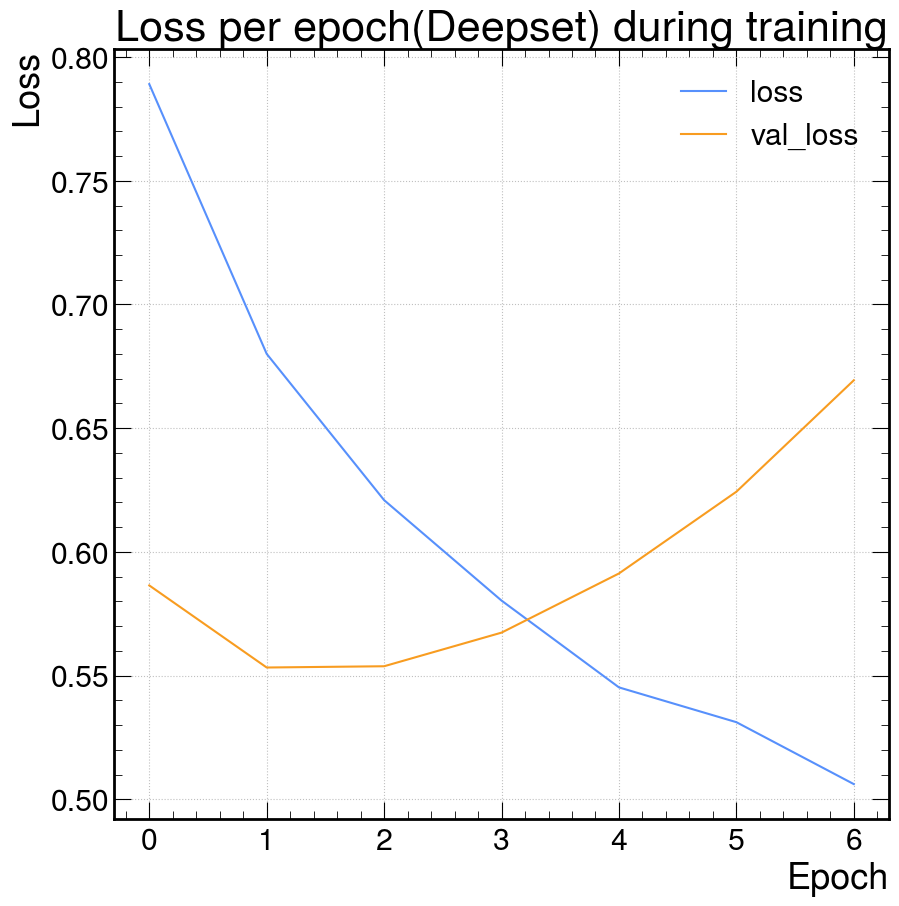

In [7]:
# Loss per epoch plot
plt.figure()
plt.plot(history_deepset_model.history['loss'], label = 'loss')
plt.plot(history_deepset_model.history['val_loss'], label = 'val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title("Loss per epoch(Deepset) during training")
plt.show()

In [8]:
predict_test_deepset = []   # Store model predictions for all test batches
label_array_test = []       # Store true labels for all test batches

# Loop over all batches in the test generator
for i, t in enumerate(test_generator):
    if t is None:
        break  # Gracefully exit if generator returns an empty batch (filtered out)
    
    print(f"Processing batch {i}, shape: {t[0].shape}")
    
    # Predict probabilities with the trained model
    batch_preds = deepset_model.predict(t[0], verbose=0)
    batch_labels = t[1]  # True one-hot encoded labels
    
    predict_test_deepset.append(batch_preds)
    label_array_test.append(batch_labels)


Processing batch 0, shape: (116, 60, 74)


In [9]:
predict_test_deepset = np.concatenate(predict_test_deepset, axis = 0)
label_array_test = np.concatenate(label_array_test, axis = 0)

fpr_deepset, tpr_deepset, threshold_deepset = roc_curve(
    label_array_test[:, 1],           # True labels for signal (H→bb)
    predict_test_deepset[:, 1]        # Predicted probability for signal
)

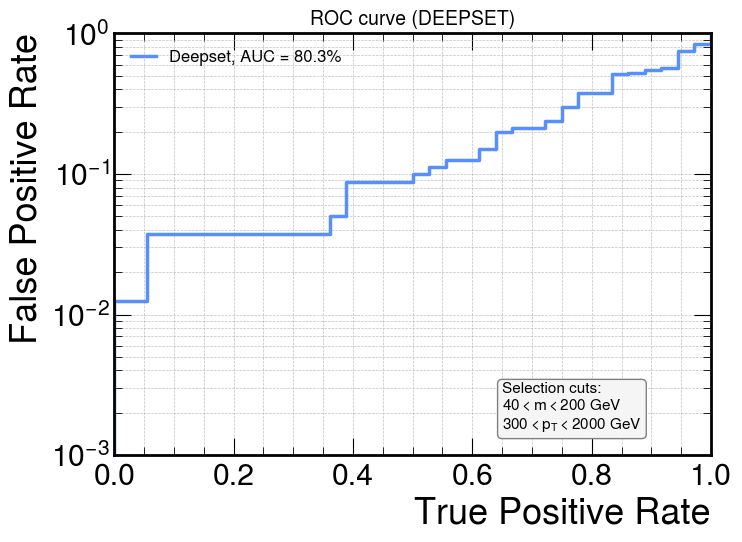

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(tpr_deepset, fpr_deepset, label=f"Deepset, AUC = {auc(fpr_deepset, tpr_deepset)*100:.1f}%", lw=2.5)
plt.semilogy()  # Set y-axis to log scale
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC curve (DEEPSET)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)

# Add selection cut box
cut_text = (
    r"Selection cuts:" + "\n"
    + r"$40 < m < 200$ GeV" + "\n"
    + r"$300 < p_T < 2000$ GeV"
)
plt.gca().text(
    0.65, 0.05, cut_text,
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='whitesmoke', edgecolor='gray')
)

plt.tight_layout()
plt.show()
